# This section will focus on Transfer Learning with TensorFlow: Fine-tuning

In [1]:
import tensorflow as tf
tf.__version__, tf.config.list_physical_devices("GPU")

('2.8.0', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [2]:
# Creating a helper function from all the previous functions
# It will now be imported for us when needed
import sys
sys.path.append("../helper/")
from helperFunctions import walk_through_dir, plot_loss_curves, unzip_data, create_tensorboard_callback

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
# Create the picture batches
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Check the batch and some of its features seperately
train_data_10_percent, train_data_10_percent.class_names

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

## Modelling experiments that will be ran
- model 0: baseline (use 10% of the training data only)
- model 1: use 1% of the training data only and augment the data
- model 2: use 10% of the training data and augment data
- model 3: use 10% of the training data and augment data and fine-tune 
- model 4: model 3 + full training data

The models will be built towards functional API rather than sequential, since it is more flexible and allows for more sophistication.

In [7]:
# 1. Model 0: built with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (in efficientnet it is built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the unputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                        experiment_name="10_percent_feature_extraction")])


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220504-213403
Epoch 1/5
24/24 [==============================] - 18s 305ms/step - loss: 1.9336 - accuracy: 0.4027 - val_loss: 1.3809 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - 5s 193ms/step - loss: 1.1746 - accuracy: 0.7360 - val_loss: 0.9194 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 5s 195ms/step - loss: 0.8483 - accuracy: 0.8027 - val_loss: 0.7426 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 5s 193ms/step - loss: 0.6951 - accuracy: 0.8267 - val_loss: 0.6604 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 5s 193ms/step - loss: 0.5987 - accuracy: 0.8533 - val_loss: 0.6156 - val_accuracy: 0.8388


In [8]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 112ms/step - loss: 0.6122 - accuracy: 0.8452


[0.6121899485588074, 0.8452000021934509]

In [9]:
# Check the layers in the base model
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [10]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [11]:
# Notice that the trainable parameters are only the output
# Additionally, model_0 technically just has 4 layers
model_0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


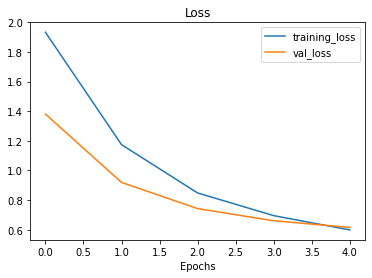

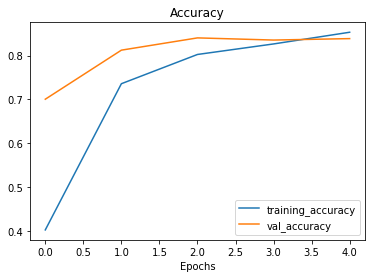

In [12]:
# Plot the loss curves
plot_loss_curves(history_0)

### Extracting a feature vector from a trained model
To demonstrate the GlobalAveragePooling2D layer, a tensor is made after going through base_model of shape (None, 7, 7, 1280), where the none is left for the batch size.

When passed through GlobaAveragePooling2D, it turns into (None, 1280).
Use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [13]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed = 42
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} \n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Random input tensor after being processd: \n {global_average_pooled_tensor} \n")

print(f"The shape of the tensor: {input_tensor.shape} \nThe shape of the vector: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[-1.0178256  -0.6905276  -0.0087332 ]
   [-0.5789686   0.6162134   0.9376349 ]
   [ 0.17766382 -0.99546874 -0.21550006]
   [ 0.23175538  0.5666746   1.6750298 ]]

  [[-1.2249361   0.7658794   0.43442637]
   [ 2.3789895   1.0340004  -0.1701912 ]
   [-0.5199478  -0.3502383  -1.9349874 ]
   [ 0.46867365  0.18043903 -0.48382837]]

  [[-0.83176696 -0.37739238  1.4195409 ]
   [ 1.1884797  -1.0452874   0.23494199]
   [-0.4151038   1.169985   -1.8412837 ]
   [ 0.6910526  -0.65649116 -0.5823141 ]]

  [[ 0.6587107  -0.8993863  -0.73738986]
   [-0.43224362  0.40781993  1.278308  ]
   [ 0.45524415 -0.5450797   0.68063545]
   [-1.8556758  -0.29843184 -0.8459964 ]]]] 

Random input tensor after being processd: 
 [[-0.03911868 -0.06983073 -0.00998169]] 

The shape of the tensor: (1, 4, 4, 3) 
The shape of the vector: (1, 3)


The processed tensor became a feature vector (lowered the dimensions to a 2D vector)

In [14]:
# Replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.03911868, -0.06983073, -0.00998169]], dtype=float32)>

## Building model_1 with 1% of the data

In [15]:
# How many images are there?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [16]:
# Create the train and test path 
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE) # batch is default

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [17]:
# Adding data augmentation right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
# Create data augmentation stage with horizontal flipping, rotation, zooms etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255)
], name="data_augmentation")

### Visualize the augmented layer

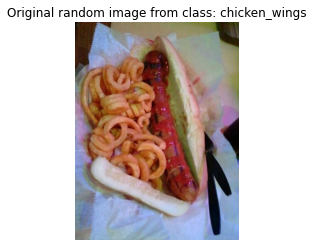

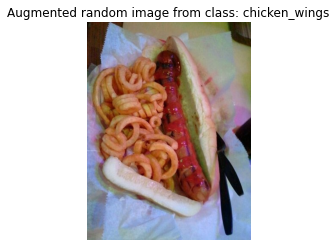

In [19]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory

random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path

# Read and plot in the random image
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Note: In the latest tensorflow versions, preprocessing the images only occurs during training of the model.

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation


In [20]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                        experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220504-213454
Epoch 1/5
3/3 [==============================] - 12s 3s/step - loss: 2.2827 - accuracy: 0.2000 - val_loss: 2.2593 - val_accuracy: 0.1734
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.0699 - accuracy: 0.2714 - val_loss: 2.1447 - val_accuracy: 0.2219
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8450 - accuracy: 0.5000 - val_loss: 2.0293 - val_accuracy: 0.2781
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7358 - accuracy: 0.5429 - val_loss: 1.9266 - val_accuracy: 0.3562
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5262 - accuracy: 0.6714 - val_loss: 1.8305 - val_accuracy: 0.4187


In [21]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [22]:
# Evaluate on the full test data
model_1.evaluate(test_data)

79/79 [==============================] - 8s 104ms/step - loss: 1.8044 - accuracy: 0.4356


[1.8043512105941772, 0.43560001254081726]

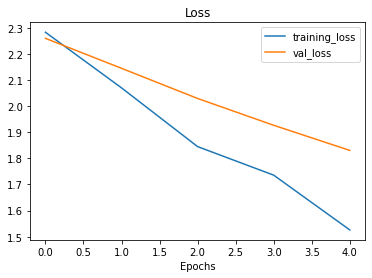

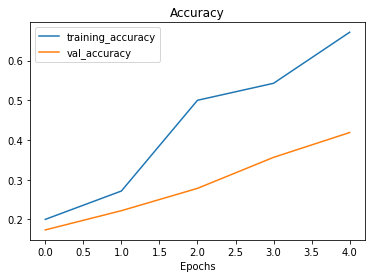

In [23]:
plot_loss_curves(history_1)

## Model 2: Feature extraction transfer learning model with 10% of the data augmented

In [24]:
# Set up the directory
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [25]:
# Set up the inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
# Create model 2 with data augmentation built in 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # layers.Rescaling(1/255) # this is efficient net so no need 
], name="data_augmentation")

In [27]:
# Setup the input shape to the model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # aug training images
x = base_model(x, training=False) # pass aug img to base model but keeps patterns unchanged for layer and batch layers
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [28]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback
This callback intermediately saves the model (the full model or partially to come and start back off where it was left off)

In [29]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   save_best=False,
                                   save_freq="epoch",
                                   verbose=1)

In [30]:
# Fit the model saving checkpoints every epoch
initial_epochs=5

history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                        experiment_name="10_percent_data_aug"),
                                        checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220504-213535
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0333 - accuracy: 0.3320
Epoch 1: saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 25s 784ms/step - loss: 2.0333 - accuracy: 0.3320 - val_loss: 1.4802 - val_accuracy: 0.6546
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.6533
Epoch 2: saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 14s 582ms/step - loss: 1.3617 - accuracy: 0.6533 - val_loss: 1.0613 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0808 - accuracy: 0.7387
Epoch 3: saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 12s 495ms/step - loss: 1.0808 - accuracy: 0.7387 - val_loss: 0.8355 - val_accuracy: 0.7993
Epoc

In [31]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 104ms/step - loss: 0.6122 - accuracy: 0.8452


[0.6121900081634521, 0.8452000021934509]

In [32]:
# Check model_2 results on all the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 8s 103ms/step - loss: 0.6991 - accuracy: 0.8080


[0.699148952960968, 0.8080000281333923]

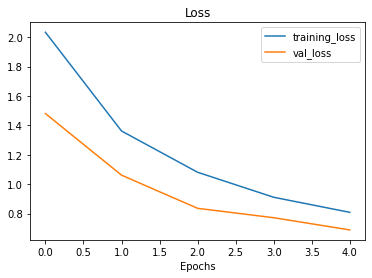

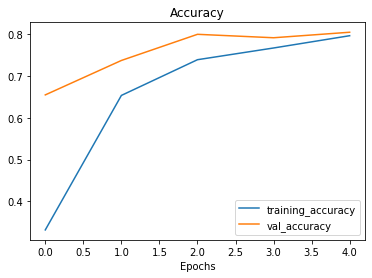

In [33]:
plot_loss_curves(history_2)

### Loading in a checkpointed weights
Loading in the checkpointed weights returns a model to a specific checkpoint

In [34]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [35]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 103ms/step - loss: 0.6991 - accuracy: 0.8080


In [36]:
# Check to see if the loaded model results are very close to the previous non-loaded results
import numpy as np
np.isclose(np.array(loaded_weights_model_results), np.array(results_10_percent_data_aug))

array([ True,  True])

In [37]:
# Check the difference between the two results
print(np.array(loaded_weights_model_results)-np.array(results_10_percent_data_aug))

[0. 0.]


## Model 3: Feature extracting with 10% of the data, augmentation and fine-tuning

In [38]:
# Layers in loaded model
model_2.layers

In [39]:
# All the layers of the efficientnet model are not trainable as seen
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000018B7EA79700> True
<keras.engine.sequential.Sequential object at 0x0000018B7EA3A9A0> True
<keras.engine.functional.Functional object at 0x0000018B7ED5D8E0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x0000018B7EA79760> True
<keras.layers.core.dense.Dense object at 0x0000018B189B1E80> True


In [40]:
# To begin fine-tuning, let start by setting the last 10 layers of the base_model.trainable to true
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (has to be done for every change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


It is good practice to lower learning rate when fine-tuning.
- Good rule of thumb is lower by at least 10x 
- Ulmfit paper talks about this more

In [41]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [42]:
# How many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [43]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model same as model_2 with more trainable layers
history_2_tuned = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        initial_epoch=history_2.epoch[-1], # Start training from the last previous epoch
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                            experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220504-213721
Epoch 5/10
24/24 [==============================] - 22s 625ms/step - loss: 0.7092 - accuracy: 0.8053 - val_loss: 0.5730 - val_accuracy: 0.8109
Epoch 6/10
24/24 [==============================] - 13s 539ms/step - loss: 0.5656 - accuracy: 0.8307 - val_loss: 0.5342 - val_accuracy: 0.8125
Epoch 7/10
24/24 [==============================] - 13s 541ms/step - loss: 0.4997 - accuracy: 0.8387 - val_loss: 0.5247 - val_accuracy: 0.8203
Epoch 8/10
24/24 [==============================] - 12s 492ms/step - loss: 0.4748 - accuracy: 0.8480 - val_loss: 0.5167 - val_accuracy: 0.8188
Epoch 9/10
24/24 [==============================] - 11s 468ms/step - loss: 0.4320 - accuracy: 0.8653 - val_loss: 0.4802 - val_accuracy: 0.8281
Epoch 10/10
24/24 [==============================] - 12s 485ms/step - loss: 0.4057 - accuracy: 0.8667 - val_loss: 0.4864 - val_accuracy: 0.8375


In [44]:
# Evaluate the fine-tune model (model_3 which is model_2 but fine-tuned)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 104ms/step - loss: 0.5164 - accuracy: 0.8272


In [45]:
# Gained around 1% from last time
results_10_percent_data_aug

[0.699148952960968, 0.8080000281333923]

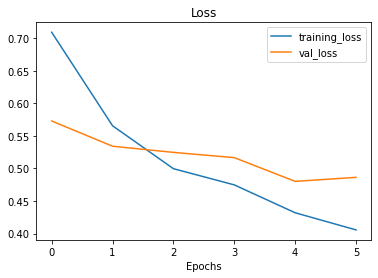

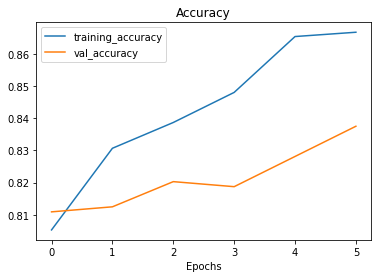

In [46]:
plot_loss_curves(history_2_tuned)

The plot_loss_curves function works great with the models. However, now a function to compare the before and after of the fine-tuning would be more convinent

In [47]:
# Creating a function to compare training and loss histories
def compare_history(original_history, new_history, initial_epochs=5):
    """ 
    Compares Two TensorFlow Histories
    """
    # Get the original history measures
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Prepare the plot
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and validation accuracy")

    # Prepare the plot
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and validation loss")

This can be used to compare future models before and after fine-tuning

## Model 4: Feature extraction using the full data, data aug, fine tuning

In [48]:
# Set up the path
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [49]:
# How many images are there?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [50]:
# Turn them to batches
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The loaded test data set is the same as the previous ones.
Time to do the following:
- Load weights from checkpoint (model_2), that way fine-tune from the same stage the 10% data model was fine-tuned from

In [51]:
model_2.load_weights(checkpoint_path)

In [52]:
# Evaluate model 2 
# Comparing it to the results of model 2, it is clear that the weights have been reverted
# The layers remain trainable however.
model_2.evaluate(test_data), results_10_percent_data_aug

79/79 [==============================] - 8s 104ms/step - loss: 0.6991 - accuracy: 0.8080


([0.6991490125656128, 0.8080000281333923],
 [0.699148952960968, 0.8080000281333923])

In [53]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [54]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

fine_tune_epochs= initial_epochs + 5
# Fit the model
history_fine_10_classes_full = model_2.fit(train_data_all,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=0.25*len(test_data),
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220504-213903
Epoch 5/10
235/235 [==============================] - 87s 341ms/step - loss: 0.6902 - accuracy: 0.7811 - val_loss: 0.3808 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 70s 299ms/step - loss: 0.4738 - accuracy: 0.8449 - val_loss: 0.3806 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 58s 246ms/step - loss: 0.4037 - accuracy: 0.8719 - val_loss: 0.3352 - val_accuracy: 0.8906
Epoch 8/10
235/235 [==============================] - 62s 263ms/step - loss: 0.3396 - accuracy: 0.8861 - val_loss: 0.3470 - val_accuracy: 0.8828
Epoch 9/10
235/235 [==============================] - 56s 236ms/step - loss: 0.2900 - accuracy: 0.9027 - val_loss: 0.3133 - val_accuracy: 0.8969
Epoch 10/10
235/235 [==============================] - 50s 213ms/step - loss: 0.2544 - accuracy: 0.9152 - val_loss: 0.3185 - val_accuracy: 0.9000


In [55]:
# Evaluate the model
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.3290 - accuracy: 0.8956


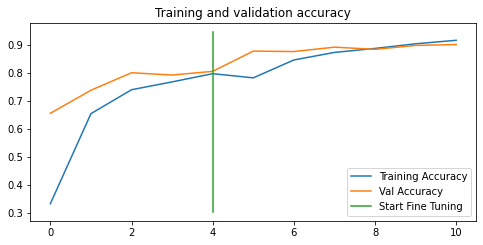

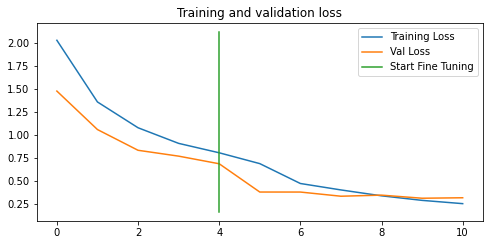

In [56]:
# How did the fine-tuning go?
compare_history(history_2,history_fine_10_classes_full)

### Viewing the experiment data on TensorBoard

- View tensorboard logs of transfer learning modelling 
https://tensorboard.dev/experiment/LLGrsrdDSwu4gKc4k0ZsAw/

- tensorboard dev upload --logdir "./transfer_learning" --name "Transfer Learning Experiment with 10 Food Types" --description "A series of different transfer learning experiments with different data volumes and fine-tuning" --one_shot